In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import struct
import matplotlib.pyplot as plt
import random
import pickle

## Neural Network

In [ ]:
class NeuralNet:
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_prime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_prime(self, x):
        return np.where(x > 0, 1, 0)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_prime(self, x):
        return 1 - np.tanh(x)**2
    
    def leaky_relu(self, x):
        return np.where(x > 0, x, x * 0.01)
    
    def leaky_relu_prime(self, x):
        return np.where(x > 0, 1, 0.01)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x))
        exps = np.where(exps == 0, 1e-10, exps)
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def softmax_prime(self, x):
        return self.softmax(x) * (1 - self.softmax(x))
    
    def random_weight(self, x, y):
        if self.activation == self.relu or self.activation == self.leaky_relu:       
            limit = np.sqrt(6 / x)
            return np.random.uniform(-limit, limit, (x, y)).astype(np.float64)
        return np.random.uniform(-1, 1, (x, y)).astype(np.float64)
    
    def normal_weight(self, x, y):
        if self.activation == self.relu or self.activation == self.leaky_relu:          
            return np.random.randn(x, y) * np.sqrt(2 / x)
        return np.random.randn(x, y).astype(np.float64)
    
    def zero_weight(self, x, y):
        return np.zeros((x, y), dtype=np.float64)
    
    def __init__(self, n_hid, hiddenlayers, input_len, output_len, activation, weight_init, learn_rate, epochs=100, batch_size=128, early_stopping=False):
        self.n_hid = n_hid
        self.hiddenlayers = hiddenlayers
        self.input_len = input_len
        self.output_len = output_len
        self.learn_rate = learn_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping

        if weight_init == 'random':
            self.weight_init = self.random_weight
        elif weight_init == 'normal':
            self.weight_init = self.normal_weight
        elif weight_init == 'zero':
            self.weight_init = self.zero_weight
        else:
            raise ValueError('Invalid weight initialization')
        
        if activation == 'relu':
            self.activation = self.relu
            self.activation_prime = self.relu_prime
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_prime = self.sigmoid_prime
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_prime = self.tanh_prime
        elif activation == 'leaky_relu':
            self.activation = self.leaky_relu
            self.activation_prime = self.leaky_relu_prime
        else:
            raise ValueError('Invalid activation function')
        
        self.weights = []
        self.biases = []

        self.weights.append(self.weight_init(self.input_len, self.hiddenlayers[0]))
        self.biases.append(self.weight_init(1, self.hiddenlayers[0]))

        for i in range(1, len(self.hiddenlayers)):
            self.weights.append(self.weight_init(self.hiddenlayers[i - 1], self.hiddenlayers[i]))
            self.biases.append(self.weight_init(1, self.hiddenlayers[i]))

        self.weights.append(self.weight_init(self.hiddenlayers[-1], self.output_len))
        self.biases.append(self.weight_init(1, self.output_len))

    def feedforward(self, x):                           # forward pass, returns the output of the network for a given input -- probability of each class
        act = x
        self.acts = [x]                        
        self.zs = []                        # z = w * x + b

        for i in range(len(self.weights) - 1):
            z = np.dot(act, self.weights[i]) + self.biases[i]       
            act = self.activation(z)
            self.acts.append(act)
            self.zs.append(z)

        z = np.dot(act, self.weights[-1]) + self.biases[-1]         # softmax 
        act = self.softmax(z)
        self.acts.append(act)
        self.zs.append(z)

        return act
    
    def loss(self, pred_proba, y):                      # cross entropy loss
        ce = np.zeros(pred_proba.shape[0])
        for i in range(len(y)):
            ce[i] = -np.log(pred_proba[i][y[i]])
        sum = np.sum(ce)
    
        return sum / ce.shape[0]
    
    def backpropagation(self, prob, y):
        delta = (prob - np.eye(self.output_len)[y])                                                 # cross entropy loss with softmax, -1/p * p' = p - 1
        self.weights[-1] -= self.learn_rate * np.dot(self.acts[-2].T, delta) / self.batch_size
        self.biases[-1] -= self.learn_rate * np.mean(delta, axis=0)

        for i in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T) * self.activation_prime(self.zs[i])
            self.weights[i] -= self.learn_rate * np.dot(self.acts[i].T, delta) / self.batch_size
            self.biases[i] -= self.learn_rate * np.mean(delta, axis=0)

    def fit(self, x, y, x_val, y_val):                  
        self.train_loss = []
        self.val_loss = []
        for epoch in range(1,self.epochs + 1):
            for i in range(0, len(x), self.batch_size):
                x_batch = x[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]

                prob = self.feedforward(x_batch)
                self.backpropagation(prob, y_batch)

            self.train_loss.append(self.loss(self.feedforward(x), y))
            self.val_loss.append(self.loss(self.feedforward(x_val), y_val))

            if epoch % 10 == 0:
                print('epoch:', epoch, 'train loss:', self.train_loss[-1], 'val loss:', self.val_loss[-1])
            # early stopping
            if self.early_stopping and epoch > 50 and np.mean(self.train_loss[-6:-2]) <= self.train_loss[-1] + 1e-5 and np.mean(self.train_loss[-7:-3]) <= self.train_loss[-1] + 1e-5:
                print('early stopping at epoch:', epoch)
                break

    def predict(self, x):
        return np.argmax(self.feedforward(x), axis=1)
    
    def predict_proba(self, x):
        return self.feedforward(x)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

## Loading data

In [16]:
def load_idx(file_path):
    """Load an MNIST `.idx` format file."""
    with open(file_path, 'rb') as f:
        magic, num_items = struct.unpack(">II", f.read(8))
        if magic == 2051:  # Images
            rows, cols = struct.unpack(">II", f.read(8))
            data = np.fromfile(f, dtype=np.uint8).reshape(num_items, rows * cols) / 255.0
        elif magic == 2049:  # Labels
            data = np.fromfile(f, dtype=np.uint8)
    return data

In [20]:
train_images = load_idx('data/train-images.idx3-ubyte')
train_labels = load_idx('data/train-labels.idx1-ubyte')
test_images = load_idx('data/t10k-images.idx3-ubyte')
test_labels = load_idx('data/t10k-labels.idx1-ubyte')

In [ ]:
np.random.seed(42)

x = np.concatenate([train_images, test_images])
y = np.concatenate([train_labels, test_labels])

idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

n = len(x)
n_train = int(n * 0.8)
n_val = int(n * 0.1)
n_test = n - n_train - n_val

# train val test split
x_train = x[:n_train]
y_train = y[:n_train]
x_val = x[n_train:n_train+n_val]
y_val = y[n_train:n_train+n_val]
x_test = x[n_train+n_val:]
y_test = y[n_train+n_val:]

In [22]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
x_val = x_val.reshape(-1, 28*28)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((56000, 784), (56000,), (7000, 784), (7000,), (7000, 784), (7000,))

In [ ]:
# normalize to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

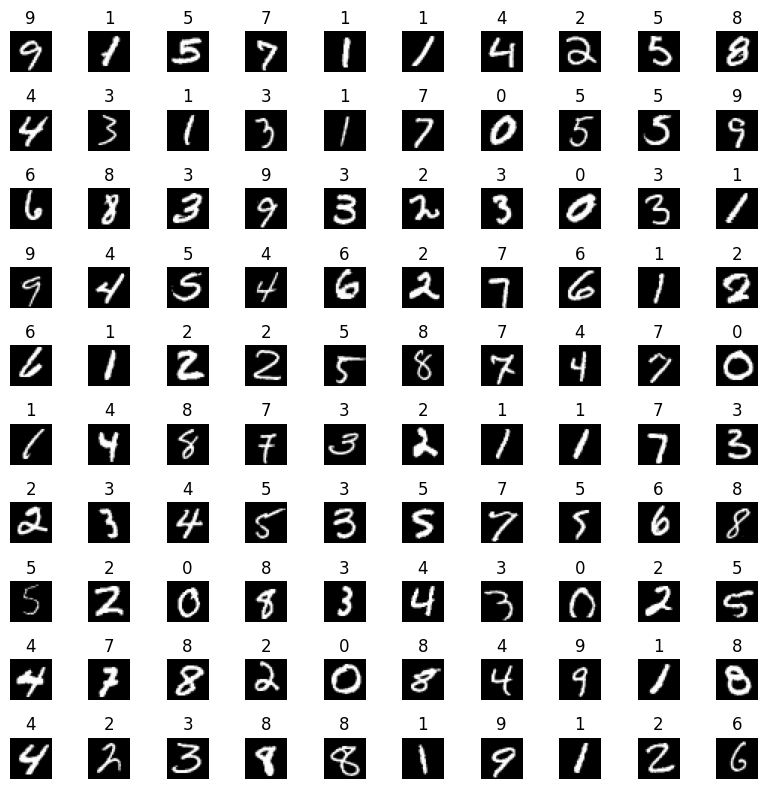

In [ ]:
# plotting the data
def plot_images(images, labels, rows=10, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    for i in range(rows):
        for j in range(cols):
            index = random.randint(0, len(images))
            axes[i, j].imshow(images[index].reshape(28, 28), cmap='gray')
            axes[i, j].set_title(labels[index])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

plot_images(x_train, y_train)

## Training the data

### Relu + Random

In [58]:
relu_random = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='relu', weight_init='random', early_stopping=False)
relu_random.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.302533279397232 val loss: 2.3011685119274063
epoch: 20 train loss: 2.3024096668184635 val loss: 2.3010382362396062
epoch: 30 train loss: 2.30237971939461 val loss: 2.300976636243327
epoch: 40 train loss: 2.3023161062468525 val loss: 2.3009154997942547
epoch: 50 train loss: 2.3023998809029753 val loss: 2.3009345787992928
epoch: 60 train loss: 2.3024260662286475 val loss: 2.300946446708343
epoch: 70 train loss: 2.302504311224289 val loss: 2.3010070834683005
epoch: 80 train loss: 2.3025946648577795 val loss: 2.301117263179714
epoch: 90 train loss: 2.302925065263403 val loss: 2.3014146410208616
epoch: 100 train loss: 2.3035621181206247 val loss: 2.3020266374049525


In [59]:
print('Train accuracy:', relu_random.score(x_train, y_train))
print('Validation accuracy:', relu_random.score(x_val, y_val))
print('Test accuracy:', relu_random.score(x_test, y_test))

Train accuracy: 0.10226785714285715
Validation accuracy: 0.10671428571428572
Test accuracy: 0.09528571428571428


In [84]:
# save model to pickle
with open('relu_random.pkl', 'wb') as f:
    pickle.dump(relu_random, f)

### Relu + Normal

In [60]:
relu_normal = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='relu', weight_init='normal', early_stopping=False)
relu_normal.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.3031923736987294 val loss: 2.302188776570358
epoch: 20 train loss: 2.3031209860169333 val loss: 2.3021176459379644
epoch: 30 train loss: 2.303079478034578 val loss: 2.3020656276509768
epoch: 40 train loss: 2.303047402860048 val loss: 2.3020211283262437
epoch: 50 train loss: 2.303025590657762 val loss: 2.3019846173442198
epoch: 60 train loss: 2.303014935501075 val loss: 2.3019571084144688
epoch: 70 train loss: 2.303017118856237 val loss: 2.3019400791687668
epoch: 80 train loss: 2.3030341031824806 val loss: 2.3019356388818246
epoch: 90 train loss: 2.3031010418471127 val loss: 2.301981930172968
epoch: 100 train loss: 2.3031565775632035 val loss: 2.302012455070436


In [61]:
print('Train accuracy:', relu_normal.score(x_train, y_train))
print('Validation accuracy:', relu_normal.score(x_val, y_val))
print('Test accuracy:', relu_normal.score(x_test, y_test))

Train accuracy: 0.11185714285714286
Validation accuracy: 0.11228571428571428
Test accuracy: 0.11814285714285715


In [85]:
with open('relu_normal.pkl', 'wb') as f:
    pickle.dump(relu_normal, f)

### Relu + Zero

In [62]:
relu_zero = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='relu', weight_init='zero', early_stopping=False)
relu_zero.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.3014200255569803 val loss: 2.3011710772553635
epoch: 20 train loss: 2.3012219643465484 val loss: 2.3008656359439903
epoch: 30 train loss: 2.3011882473158125 val loss: 2.3007847135428743
epoch: 40 train loss: 2.3011824032742796 val loss: 2.3007579402177765
epoch: 50 train loss: 2.301181364030809 val loss: 2.3007475851006634
epoch: 60 train loss: 2.301181173544364 val loss: 2.3007432401383796
epoch: 70 train loss: 2.301181137416241 val loss: 2.3007413494620907
epoch: 80 train loss: 2.301181130317566 val loss: 2.300740514015715
epoch: 90 train loss: 2.3011811288886235 val loss: 2.3007401424513314
epoch: 100 train loss: 2.30118112860864 val loss: 2.3007399767290355


In [63]:
print('Train accuracy:', relu_zero.score(x_train, y_train))
print('Validation accuracy:', relu_zero.score(x_val, y_val))
print('Test accuracy:', relu_zero.score(x_test, y_test))

Train accuracy: 0.11185714285714286
Validation accuracy: 0.11228571428571428
Test accuracy: 0.11814285714285715


In [86]:
with open('relu_zero.pkl', 'wb') as f:
    pickle.dump(relu_zero, f)

### Sigmoid + Random

In [65]:
sigmoid_random = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='sigmoid', weight_init='random', early_stopping=False)
sigmoid_random.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.3000895871059135 val loss: 2.2995649370940305
epoch: 20 train loss: 2.2997609040073166 val loss: 2.2992364568872055
epoch: 30 train loss: 2.2994112274886622 val loss: 2.298886646374365
epoch: 40 train loss: 2.2990372589709813 val loss: 2.2985124450109895
epoch: 50 train loss: 2.2986362430341707 val loss: 2.298111338593532
epoch: 60 train loss: 2.2982071489311715 val loss: 2.2976824938279656
epoch: 70 train loss: 2.2977519543018117 val loss: 2.2972279476384507
epoch: 80 train loss: 2.2972759910128095 val loss: 2.2967528760675733
epoch: 90 train loss: 2.2967863130898247 val loss: 2.296263968595581
epoch: 100 train loss: 2.296288727474775 val loss: 2.2957665558201197


In [66]:
print('Train accuracy:', sigmoid_random.score(x_train, y_train))
print('Validation accuracy:', sigmoid_random.score(x_val, y_val))
print('Test accuracy:', sigmoid_random.score(x_test, y_test))

Train accuracy: 0.11217857142857143
Validation accuracy: 0.11257142857142857
Test accuracy: 0.11828571428571429


In [87]:
with open('sigmoid_random.pkl', 'wb') as f:
    pickle.dump(sigmoid_random, f)

### Sigmoid + Normal

In [67]:
sigmoid_normal = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='sigmoid', weight_init='normal', early_stopping=False)
sigmoid_normal.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.280429186367357 val loss: 2.2787577534286365
epoch: 20 train loss: 2.2648998416906423 val loss: 2.2629124996632606
epoch: 30 train loss: 2.249850077951818 val loss: 2.2475957288862776
epoch: 40 train loss: 2.2361984707378975 val loss: 2.233857379676308
epoch: 50 train loss: 2.2217235541760663 val loss: 2.2192894894257162
epoch: 60 train loss: 2.2041926473091893 val loss: 2.2015768690379622
epoch: 70 train loss: 2.1837622028240147 val loss: 2.1809837047509437
epoch: 80 train loss: 2.1619285519546616 val loss: 2.1590308827584535
epoch: 90 train loss: 2.1375625995362286 val loss: 2.13458560498864
epoch: 100 train loss: 2.1086832916067366 val loss: 2.1058014444388866


In [68]:
print('Train accuracy:', sigmoid_normal.score(x_train, y_train))
print('Validation accuracy:', sigmoid_normal.score(x_val, y_val))
print('Test accuracy:', sigmoid_normal.score(x_test, y_test))

Train accuracy: 0.3604107142857143
Validation accuracy: 0.363
Test accuracy: 0.357


In [88]:
with open('sigmoid_normal.pkl', 'wb') as f:
    pickle.dump(sigmoid_normal, f)

### Sigmoid + Zero

In [69]:
sigmoid_zero = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='sigmoid', weight_init='zero', early_stopping=False)
sigmoid_zero.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.3011897389794025 val loss: 2.300726675921646
epoch: 20 train loss: 2.301189742459215 val loss: 2.300726366388017
epoch: 30 train loss: 2.3011897445602902 val loss: 2.300726364322174
epoch: 40 train loss: 2.30118974665454 val loss: 2.3007263624685286
epoch: 50 train loss: 2.3011897487496893 val loss: 2.300726360613887
epoch: 60 train loss: 2.301189750845744 val loss: 2.300726358758094
epoch: 70 train loss: 2.3011897529427063 val loss: 2.300726356901152
epoch: 80 train loss: 2.301189755040576 val loss: 2.3007263550430594
epoch: 90 train loss: 2.301189757139352 val loss: 2.300726353183817
epoch: 100 train loss: 2.3011897592390356 val loss: 2.3007263513234264


In [70]:
print('Train accuracy:', sigmoid_zero.score(x_train, y_train))
print('Validation accuracy:', sigmoid_zero.score(x_val, y_val))
print('Test accuracy:', sigmoid_zero.score(x_test, y_test))

Train accuracy: 0.11185714285714286
Validation accuracy: 0.11228571428571428
Test accuracy: 0.11814285714285715


In [89]:
with open('sigmoid_zero.pkl', 'wb') as f:
    pickle.dump(sigmoid_zero, f)

### Tanh + Random

In [71]:
tanh_random = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='tanh', weight_init='random', early_stopping=False)
tanh_random.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 1.4473753615596472 val loss: 1.445099489926801
epoch: 20 train loss: 1.0885904549994097 val loss: 1.088733078789408
epoch: 30 train loss: 0.9251660518790438 val loss: 0.9272702869896307
epoch: 40 train loss: 0.8309379212518876 val loss: 0.8341754463014588
epoch: 50 train loss: 0.7523618386809624 val loss: 0.7545164049190591
epoch: 60 train loss: 0.6820148632163359 val loss: 0.682665538523918
epoch: 70 train loss: 0.6236371645120913 val loss: 0.6229122882755281
epoch: 80 train loss: 0.5796278304617615 val loss: 0.5784631289503872
epoch: 90 train loss: 0.5449952582218989 val loss: 0.5442908960454294
epoch: 100 train loss: 0.5145095561119645 val loss: 0.5148261687463348


In [72]:
print('Train accuracy:', tanh_random.score(x_train, y_train))
print('Validation accuracy:', tanh_random.score(x_val, y_val))
print('Test accuracy:', tanh_random.score(x_test, y_test))

Train accuracy: 0.8492678571428571
Validation accuracy: 0.8498571428571429
Test accuracy: 0.8488571428571429


In [90]:
with open('tanh_random.pkl', 'wb') as f:
    pickle.dump(tanh_random, f)

### Tanh + Normal

In [73]:
tanh_normal = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='tanh', weight_init='normal', early_stopping=False)
tanh_normal.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 1.577467337850735 val loss: 1.592685595444883
epoch: 20 train loss: 1.3907133073939428 val loss: 1.4041128059496883
epoch: 30 train loss: 1.2124523035098562 val loss: 1.223060840769209
epoch: 40 train loss: 1.1181969552049502 val loss: 1.1280977567055719
epoch: 50 train loss: 1.036416043338113 val loss: 1.0452304457876702
epoch: 60 train loss: 0.9598918751688001 val loss: 0.9703528991330452
epoch: 70 train loss: 0.9123725450602539 val loss: 0.925418591174799
epoch: 80 train loss: 0.8770554737331994 val loss: 0.8921355889604874
epoch: 90 train loss: 0.8380388954810623 val loss: 0.8540691670995921
epoch: 100 train loss: 0.8006619997094087 val loss: 0.8168014995875938


In [74]:
print('Train accuracy:', tanh_normal.score(x_train, y_train))
print('Validation accuracy:', tanh_normal.score(x_val, y_val))
print('Test accuracy:', tanh_normal.score(x_test, y_test))

Train accuracy: 0.7513392857142858
Validation accuracy: 0.7471428571428571
Test accuracy: 0.7485714285714286


In [91]:
with open('tanh_normal.pkl', 'wb') as f:
    pickle.dump(tanh_normal, f)

### Tanh + Zero

In [75]:
tanh_zero = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='tanh', weight_init='zero', early_stopping=False)
tanh_zero.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.3014200255569803 val loss: 2.3011710772553635
epoch: 20 train loss: 2.3012219643465484 val loss: 2.3008656359439903
epoch: 30 train loss: 2.3011882473158125 val loss: 2.3007847135428743
epoch: 40 train loss: 2.3011824032742796 val loss: 2.3007579402177765
epoch: 50 train loss: 2.301181364030809 val loss: 2.3007475851006634
epoch: 60 train loss: 2.301181173544364 val loss: 2.3007432401383796
epoch: 70 train loss: 2.301181137416241 val loss: 2.3007413494620907
epoch: 80 train loss: 2.301181130317566 val loss: 2.300740514015715
epoch: 90 train loss: 2.3011811288886235 val loss: 2.3007401424513314
epoch: 100 train loss: 2.30118112860864 val loss: 2.3007399767290355


In [76]:
print('Train accuracy:', tanh_zero.score(x_train, y_train))
print('Validation accuracy:', tanh_zero.score(x_val, y_val))
print('Test accuracy:', tanh_zero.score(x_test, y_test))

Train accuracy: 0.11185714285714286
Validation accuracy: 0.11228571428571428
Test accuracy: 0.11814285714285715


In [92]:
with open('tanh_zero.pkl', 'wb') as f:
    pickle.dump(tanh_zero, f)

### Leaky Relu + Random

In [77]:
leaky_relu_random = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='leaky_relu', weight_init='random', early_stopping=False)
leaky_relu_random.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.305032891809814 val loss: 2.304054459616786
epoch: 20 train loss: 2.3050442162887195 val loss: 2.304055441300012
epoch: 30 train loss: 2.3050870982267813 val loss: 2.3040862456692284
epoch: 40 train loss: 2.305163419976106 val loss: 2.304146985027259
epoch: 50 train loss: 2.305249572459818 val loss: 2.3042135057030486
epoch: 60 train loss: 2.305401299072673 val loss: 2.304340028012526
epoch: 70 train loss: 2.3055938500580875 val loss: 2.304499304279268
epoch: 80 train loss: 2.3059214734106677 val loss: 2.304820214102725
epoch: 90 train loss: 2.3060799263432883 val loss: 2.3049015369221166
epoch: 100 train loss: 2.3064091342350768 val loss: 2.3051522981079895


In [78]:
print('Train accuracy:', leaky_relu_random.score(x_train, y_train))
print('Validation accuracy:', leaky_relu_random.score(x_val, y_val))
print('Test accuracy:', leaky_relu_random.score(x_test, y_test))

Train accuracy: 0.10226785714285715
Validation accuracy: 0.10671428571428572
Test accuracy: 0.09528571428571428


In [93]:
with open('leaky_relu_random.pkl', 'wb') as f:
    pickle.dump(leaky_relu_random, f)

### Leaky Relu + Normal

In [79]:
leaky_relu_normal = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='leaky_relu', weight_init='normal', early_stopping=False)
leaky_relu_normal.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.3043021284523832 val loss: 2.3036060047096454
epoch: 20 train loss: 2.3042507862436286 val loss: 2.3035367896872283
epoch: 30 train loss: 2.3042064973174035 val loss: 2.303474299360565
epoch: 40 train loss: 2.304172885011064 val loss: 2.3034211110987926
epoch: 50 train loss: 2.304156654427881 val loss: 2.303379070236677
epoch: 60 train loss: 2.304139753066971 val loss: 2.303344539929709
epoch: 70 train loss: 2.3041408336648255 val loss: 2.3033220886017576
epoch: 80 train loss: 2.3041547885332934 val loss: 2.303311257676663
epoch: 90 train loss: 2.3042139854867925 val loss: 2.3033523524666313
epoch: 100 train loss: 2.3042519404248036 val loss: 2.3033633302814938


In [80]:
print('Train accuracy:', leaky_relu_normal.score(x_train, y_train))
print('Validation accuracy:', leaky_relu_normal.score(x_val, y_val))
print('Test accuracy:', leaky_relu_normal.score(x_test, y_test))

Train accuracy: 0.10226785714285715
Validation accuracy: 0.10671428571428572
Test accuracy: 0.09528571428571428


In [94]:
with open('leaky_relu_normal.pkl', 'wb') as f:
    pickle.dump(leaky_relu_normal, f)

### Leaky Relu + Zero

In [99]:
leaky_relu_zero = NeuralNet(n_hid=4, hiddenlayers=[256, 128, 64, 32], input_len=784, output_len=10, learn_rate=2e-3, activation='leaky_relu', weight_init='random', early_stopping=False)
leaky_relu_zero.fit(x_train, y_train, x_val, y_val)

epoch: 10 train loss: 2.3037254956891218 val loss: 2.302475096546917
epoch: 20 train loss: 2.303767426890588 val loss: 2.3024912049730433
epoch: 30 train loss: 2.303880533387858 val loss: 2.3025558662601937
epoch: 40 train loss: 2.3040095208505087 val loss: 2.3026993442307515
epoch: 50 train loss: 2.3042047107792034 val loss: 2.3028435208804305
epoch: 60 train loss: 2.3044750957577427 val loss: 2.303054455380769
epoch: 70 train loss: 2.304810701940396 val loss: 2.3033471265959267
epoch: 80 train loss: 2.305313607592774 val loss: 2.3037729508067772
epoch: 90 train loss: 2.3060154405123767 val loss: 2.3043836849119965
epoch: 100 train loss: 2.307023701308522 val loss: 2.305282351320243


In [100]:
print('Train accuracy:', leaky_relu_zero.score(x_train, y_train))
print('Validation accuracy:', leaky_relu_zero.score(x_val, y_val))
print('Test accuracy:', leaky_relu_zero.score(x_test, y_test))

Train accuracy: 0.10226785714285715
Validation accuracy: 0.10671428571428572
Test accuracy: 0.09528571428571428


In [101]:
with open('leaky_relu_zero.pkl', 'wb') as f:
    pickle.dump(leaky_relu_zero, f)

## Plotting the loss curves

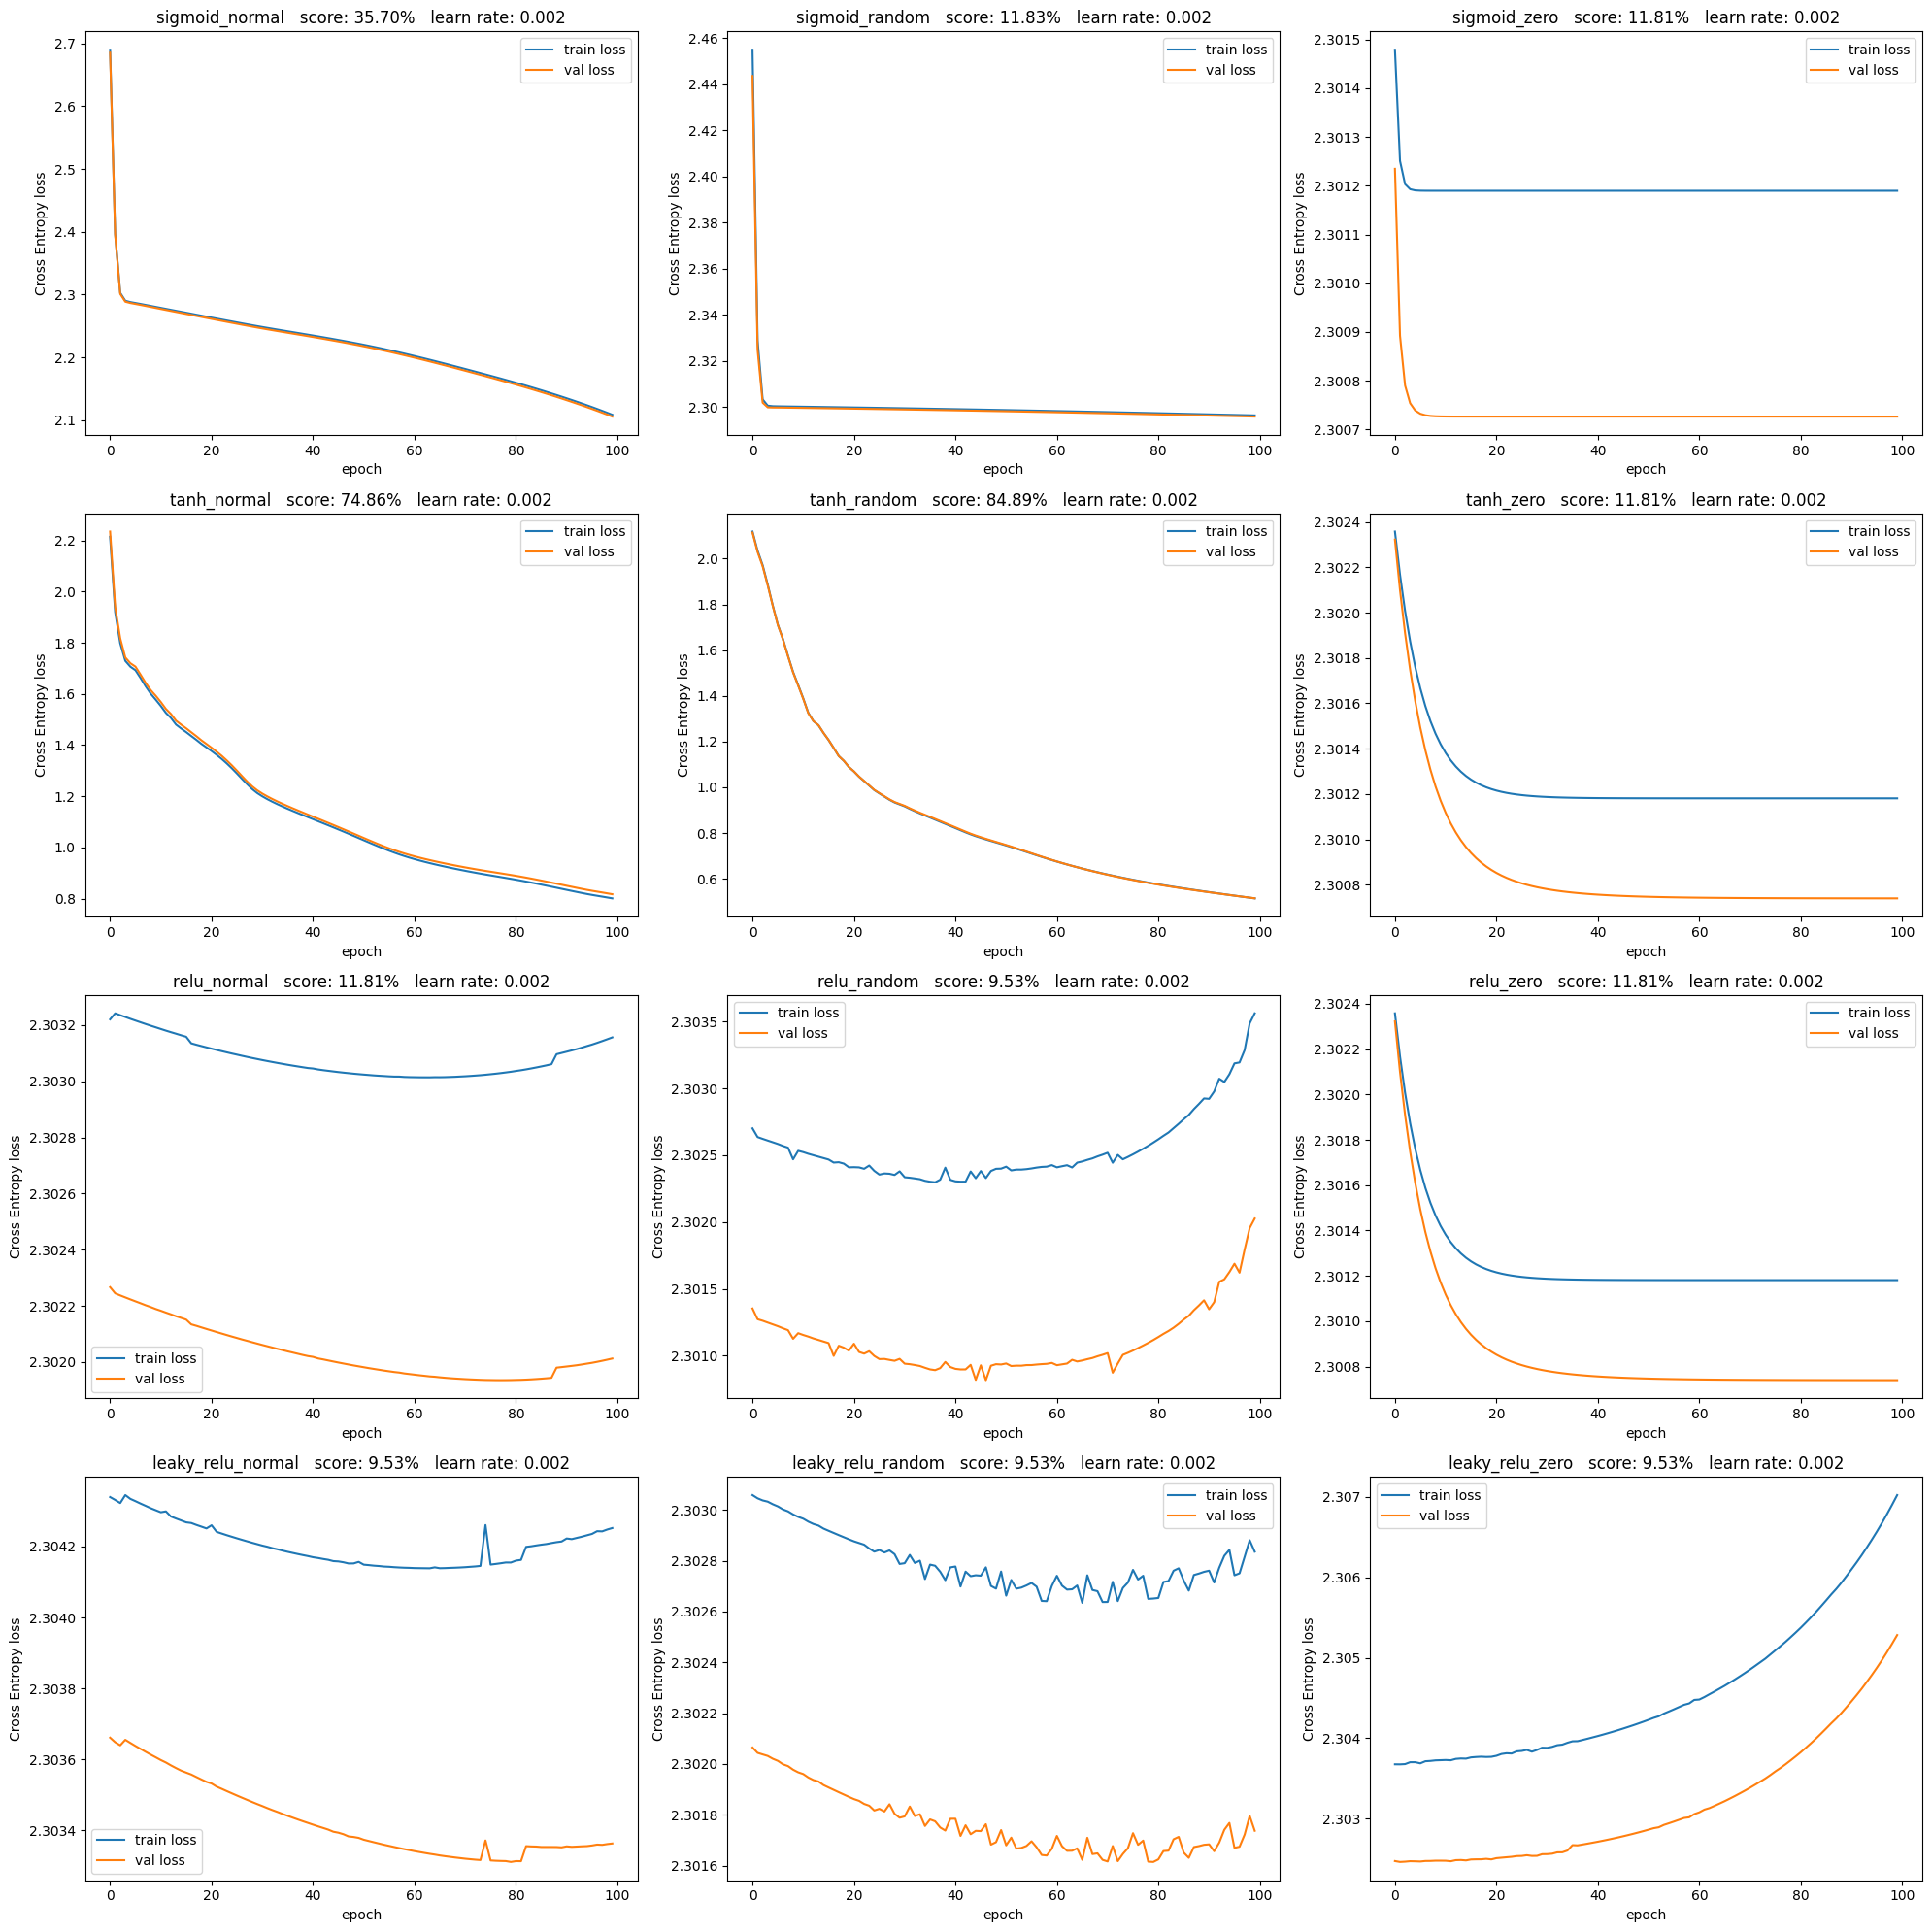

In [ ]:
activation = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
weight_init = ['normal', 'random', 'zero']


plt.figure(figsize=(20, 20))
for act in activation:
    for weight in weight_init:
        model = pickle.load(open(f'{act}_{weight}.pkl', 'rb'))

        plt.subplot(4, 3, activation.index(act) * 3 + weight_init.index(weight) + 1)
        plt.plot(model.train_loss, label='train loss')
        plt.plot(model.val_loss, label='val loss')
        plt.title(f'{act}_{weight}   ' + f'score: {model.score(x_test, y_test) * 100:.2f}% ' + f'  learn rate: {model.learn_rate}')
        plt.xlabel('epoch')
        plt.ylabel('Cross Entropy loss')
        plt.legend()

        del model

plt.tight_layout()
plt.show()


- All models were run at most 100 epochs and batch size 128.
- Learning rate = 0.002 and 'Adam' solver
- ReLU and Leaky ReLU activation functions are highly sensitive to initialization of weights and learning rate.
- From the plots tanh seemed to perform the best given same initialisation and learning rates for all.